## House Price Prediction - Assignment 
## -----------------------------------------------------

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [126]:
# reading the dataset
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [127]:
# Check the dimensions
data.shape

(1460, 81)

In [128]:
# Check for column details
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [129]:
#checking duplicates
sum(data.duplicated(subset = 'Id')) == 0

True

In [130]:
# Checking for percentage nulls
round(100*(data.isnull().sum()/len(data.index)), 2)


Id                  0
MSSubClass          0
MSZoning            0
LotFrontage        18
LotArea             0
Street              0
Alley              94
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType       0.55
MasVnrArea       0.55
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu        47
GarageType        5.5
GarageYrBlt       5.5
GarageFinish      5.5
GarageCars          0
GarageArea          0
GarageQual        5.5
GarageCond        5.5
PavedDrive

In [131]:
# since, it is clear that there are multiple columns with high nulls, lets group them together
data.columns[data.isnull().any()] 

null = data.isnull().sum()/len(data)*100
null = null[null>0]
null.sort_values(inplace=True, ascending=False)
null

PoolQC         1e+02
MiscFeature       96
Alley             94
Fence             81
FireplaceQu       47
LotFrontage       18
GarageYrBlt      5.5
GarageType       5.5
GarageFinish     5.5
GarageQual       5.5
GarageCond       5.5
BsmtFinType2     2.6
BsmtExposure     2.6
BsmtFinType1     2.5
BsmtCond         2.5
BsmtQual         2.5
MasVnrArea      0.55
MasVnrType      0.55
Electrical     0.068
dtype: float64

In [132]:
# According to the data dictionary provided, the nulls in these columns indicates the absence of facility which may affect the price
# Hence, we will first impute the categorical variables with 'None'
null_with_meaning = ["Alley", "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for i in null_with_meaning:
    data[i].fillna("None", inplace=True)

In [133]:
# Check nulls once again

data.columns[data.isnull().any()] 

null_2 = data.isnull().sum()/len(data)*100
null_2 = null_2[null_2>0]
null_2.sort_values(inplace=True, ascending=False)
null_2

LotFrontage      18
GarageYrBlt     5.5
MasVnrArea     0.55
Electrical    0.068
dtype: float64

In [134]:
# Will check these columns one by one
data['LotFrontage'].describe()

count   1.2e+03
mean         70
std          24
min          21
25%          59
50%          69
75%          80
max     3.1e+02
Name: LotFrontage, dtype: float64

In [135]:
data['GarageYrBlt'].describe()

count   1.4e+03
mean      2e+03
std          25
min     1.9e+03
25%       2e+03
50%       2e+03
75%       2e+03
max       2e+03
Name: GarageYrBlt, dtype: float64

In [136]:
data['MasVnrArea'].describe()

count   1.5e+03
mean      1e+02
std     1.8e+02
min           0
25%           0
50%           0
75%     1.7e+02
max     1.6e+03
Name: MasVnrArea, dtype: float64

In [137]:
data['Electrical'].describe()

count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object

In [138]:
# As per the data dictionary "LotFrontage" is Linear feet of street connected to property.  
# Since it is a numeric with a fair distribution, it can be imputed with similar 'Neighborhood' values

data['LotFrontage'] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
data["GarageYrBlt"].fillna(data["GarageYrBlt"].median(), inplace=True)
data["MasVnrArea"].fillna(data["MasVnrArea"].median(), inplace=True)
data["Electrical"].dropna(inplace=True)

In [139]:
# Crosscheck the updated 'LotFrontage' column
data['LotFrontage'].describe()

count   1.5e+03
mean         70
std          22
min          21
25%          60
50%          70
75%          80
max     3.1e+02
Name: LotFrontage, dtype: float64

In [140]:
data['GarageYrBlt'].describe()

count   1.5e+03
mean      2e+03
std          24
min     1.9e+03
25%       2e+03
50%       2e+03
75%       2e+03
max       2e+03
Name: GarageYrBlt, dtype: float64

In [141]:
data['MasVnrArea'].describe()

count   1.5e+03
mean      1e+02
std     1.8e+02
min           0
25%           0
50%           0
75%     1.6e+02
max     1.6e+03
Name: MasVnrArea, dtype: float64

In [142]:
data['Electrical'].describe()

count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object

In [143]:
# Check the no. of rows retained
len(data.index)
len(data.index)/1460

1.0

### Some EDA on the cleaned data

In [144]:
# all numeric (float and int) variables in the dataset
data_numeric = data.select_dtypes(include=['float64', 'int64'])
data_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65,8450,7,5,2003,2003,2e+02,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80,9600,6,8,1976,1976,0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68,11250,7,5,2001,2002,1.6e+02,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60,9550,7,5,1915,1970,0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84,14260,8,5,2000,2000,3.5e+02,655,...,192,84,0,0,0,0,0,12,2008,250000


In [145]:
# Drop 'Id'

data_numeric = data_numeric.drop(['Id'], axis=1)
data_numeric.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65,8450,7,5,2003,2003,2e+02,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80,9600,6,8,1976,1976,0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68,11250,7,5,2001,2002,1.6e+02,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60,9550,7,5,1915,1970,0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84,14260,8,5,2000,2000,3.5e+02,655,0,...,192,84,0,0,0,0,0,12,2008,250000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

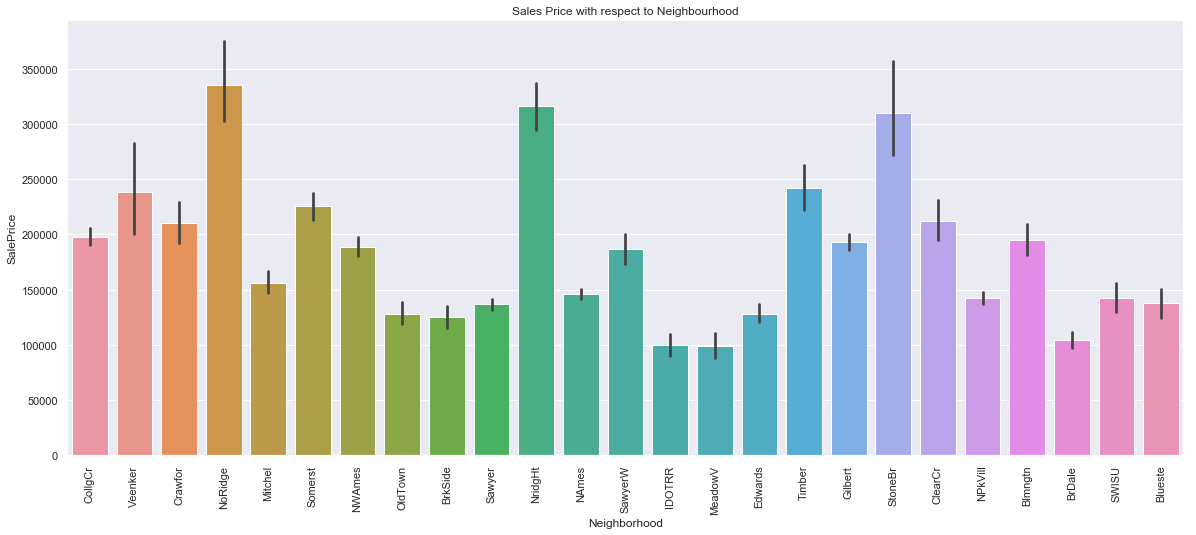

In [146]:
# plot 'Sale Price' with respect to 'Neighborhood'

plt.figure(figsize=(20, 8))
sns.barplot(x="Neighborhood", y="SalePrice", data= data)
plt.title("Sales Price with respect to Neighbourhood")
plt.xticks(rotation=90)

####  Properties in some of the Neighborhoods are high priced

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

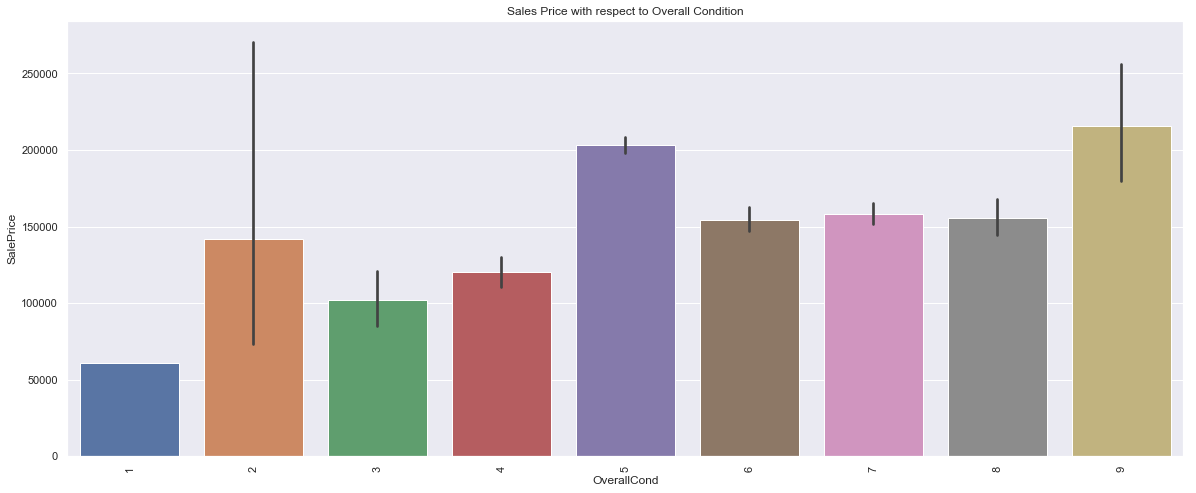

In [147]:
# plot 'overall condition' with respect to 'Saleprice'

plt.figure(figsize=(20, 8))
sns.barplot(x="OverallCond", y="SalePrice", data= data)
plt.title("Sales Price with respect to Overall Condition")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

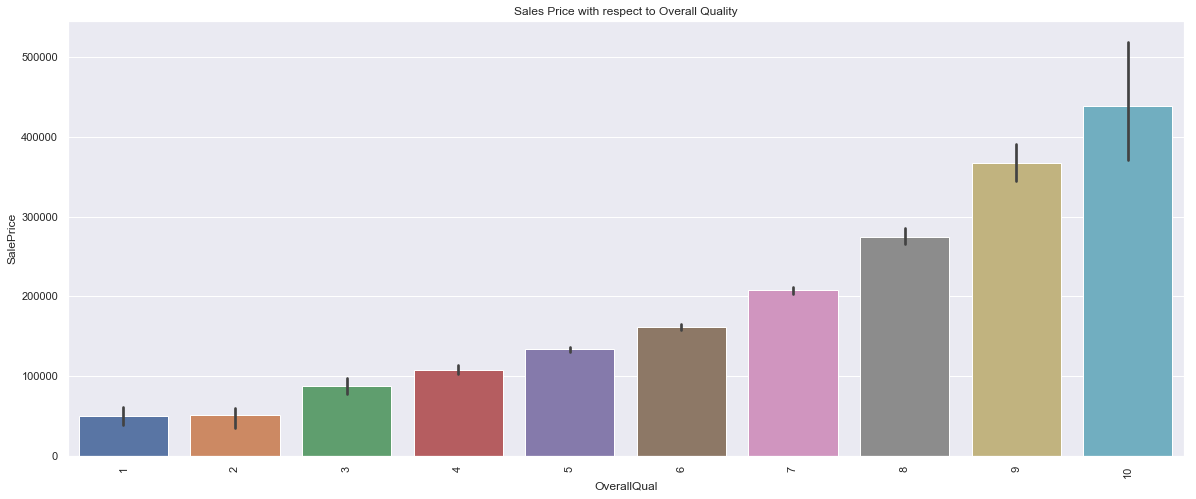

In [148]:
# plot 'overall quality' with respect to 'Saleprice'

plt.figure(figsize=(20, 8))
sns.barplot(x="OverallQual", y="SalePrice", data= data)
plt.title("Sales Price with respect to Overall Quality")
plt.xticks(rotation=90)

####                                  Increase in the overall quality has a direct positive effect on the sale price

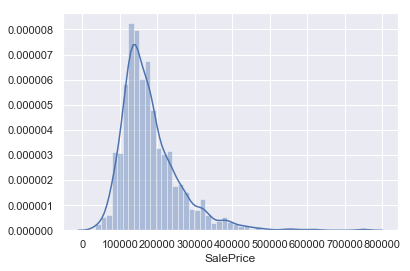

In [149]:
sns.distplot(data['SalePrice'])

In [150]:
data_raw = data.copy

In [151]:
# since the Saleprice figures are skewed towards left, we will apply the log transformation to obtain a centralized data
data['SalePrice']=np.log1p(data['SalePrice'])

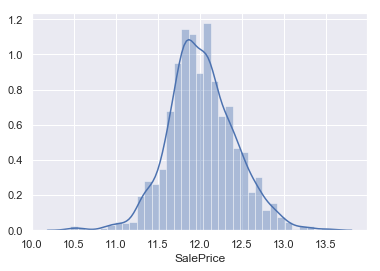

In [152]:
sns.distplot(data['SalePrice'])

In [153]:
# correlation matrix
cor = data_numeric.corr()
cor

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1,-0.37,-0.14,0.033,-0.059,0.028,0.041,0.024,-0.07,-0.066,...,-0.013,-0.0061,-0.012,-0.044,-0.026,0.0083,-0.0077,-0.014,-0.021,-0.084
LotFrontage,-0.37,1,0.34,0.24,-0.044,0.12,0.085,0.2,0.23,0.052,...,0.089,0.14,0.0081,0.065,0.041,0.17,0.0053,0.0074,0.0048,0.35
LotArea,-0.14,0.34,1,0.11,-0.0056,0.014,0.014,0.1,0.21,0.11,...,0.17,0.085,-0.018,0.02,0.043,0.078,0.038,0.0012,-0.014,0.26
OverallQual,0.033,0.24,0.11,1,-0.092,0.57,0.55,0.41,0.24,-0.059,...,0.24,0.31,-0.11,0.03,0.065,0.065,-0.031,0.071,-0.027,0.79
OverallCond,-0.059,-0.044,-0.0056,-0.092,1,-0.38,0.074,-0.13,-0.046,0.04,...,-0.0033,-0.033,0.07,0.026,0.055,-0.002,0.069,-0.0035,0.044,-0.078
YearBuilt,0.028,0.12,0.014,0.57,-0.38,1,0.59,0.31,0.25,-0.049,...,0.22,0.19,-0.39,0.031,-0.05,0.0049,-0.034,0.012,-0.014,0.52
YearRemodAdd,0.041,0.085,0.014,0.55,0.074,0.59,1,0.18,0.13,-0.068,...,0.21,0.23,-0.19,0.045,-0.039,0.0058,-0.01,0.021,0.036,0.51
MasVnrArea,0.024,0.2,0.1,0.41,-0.13,0.31,0.18,1,0.26,-0.071,...,0.16,0.12,-0.11,0.019,0.062,0.012,-0.03,-0.0067,-0.0083,0.47
BsmtFinSF1,-0.07,0.23,0.21,0.24,-0.046,0.25,0.13,0.26,1,-0.05,...,0.2,0.11,-0.1,0.026,0.062,0.14,0.0036,-0.016,0.014,0.39
BsmtFinSF2,-0.066,0.052,0.11,-0.059,0.04,-0.049,-0.068,-0.071,-0.05,1,...,0.068,0.0031,0.037,-0.03,0.089,0.042,0.0049,-0.015,0.032,-0.011


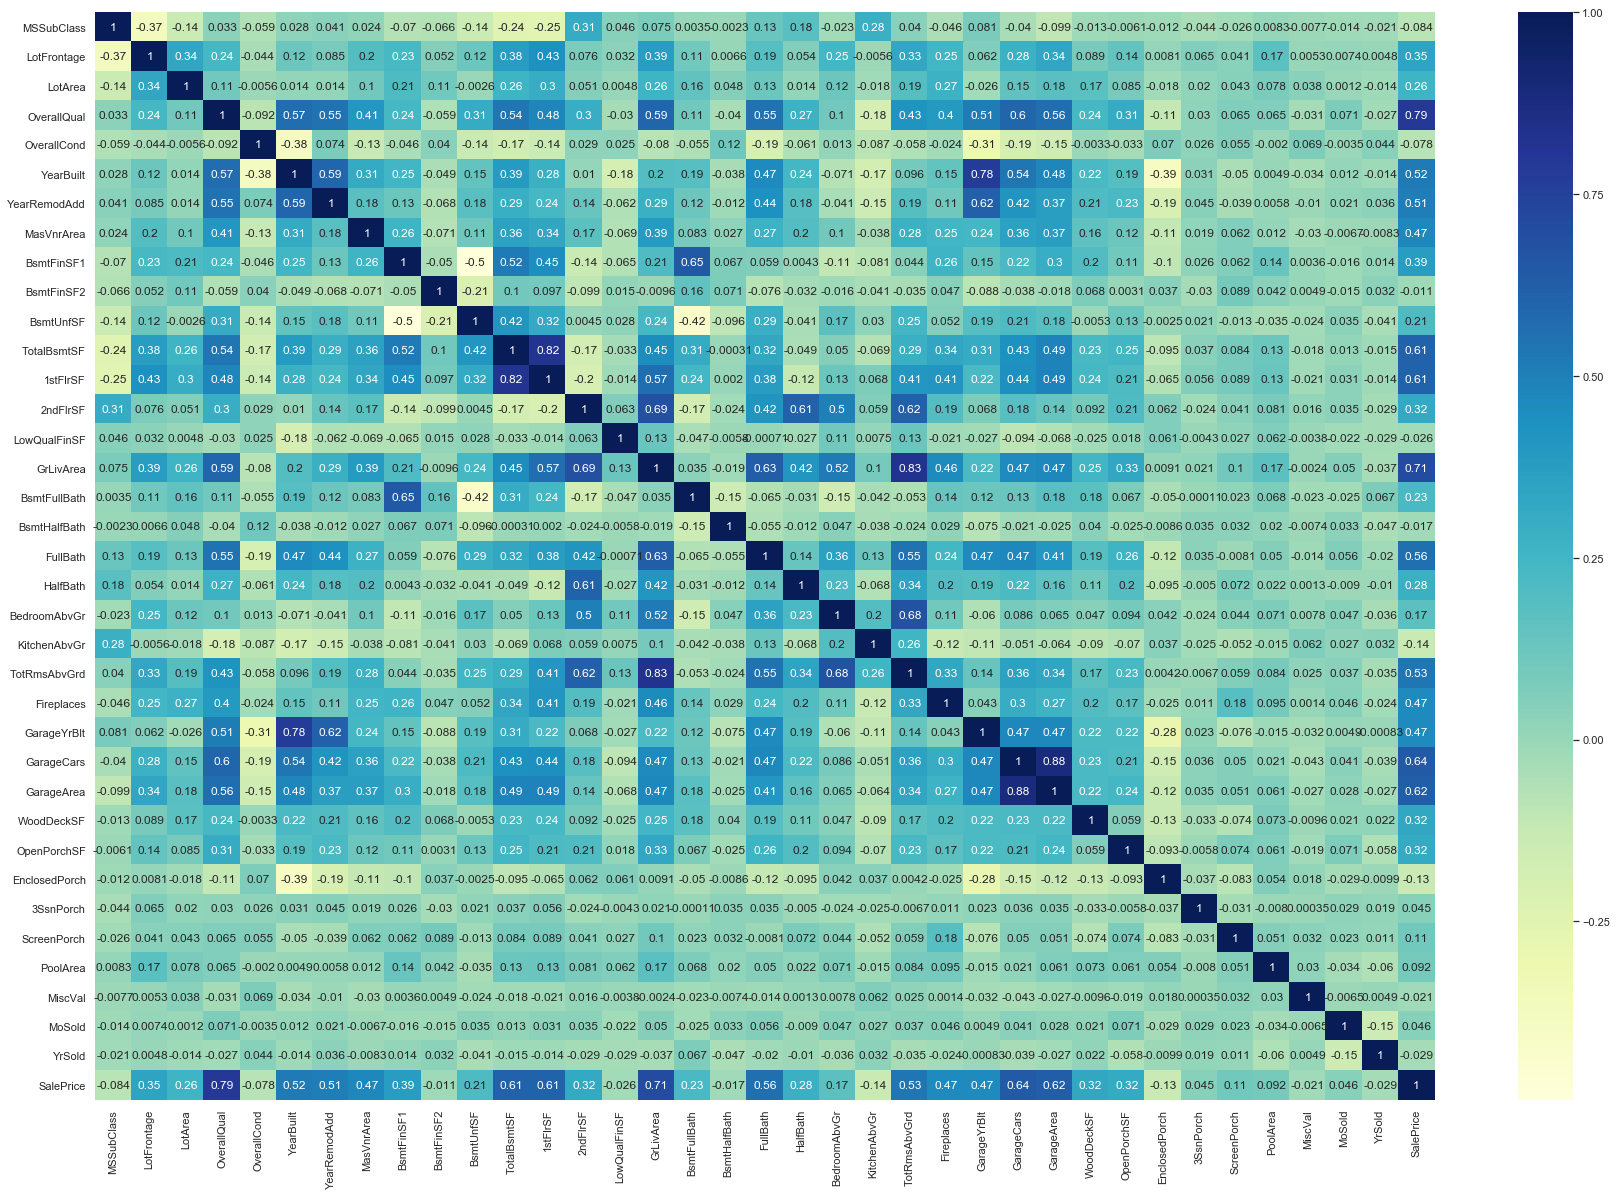

In [154]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(30,20))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

####  We can see that some of the variables are correlated
#### Before dropping these columns, we will first check their predictive power

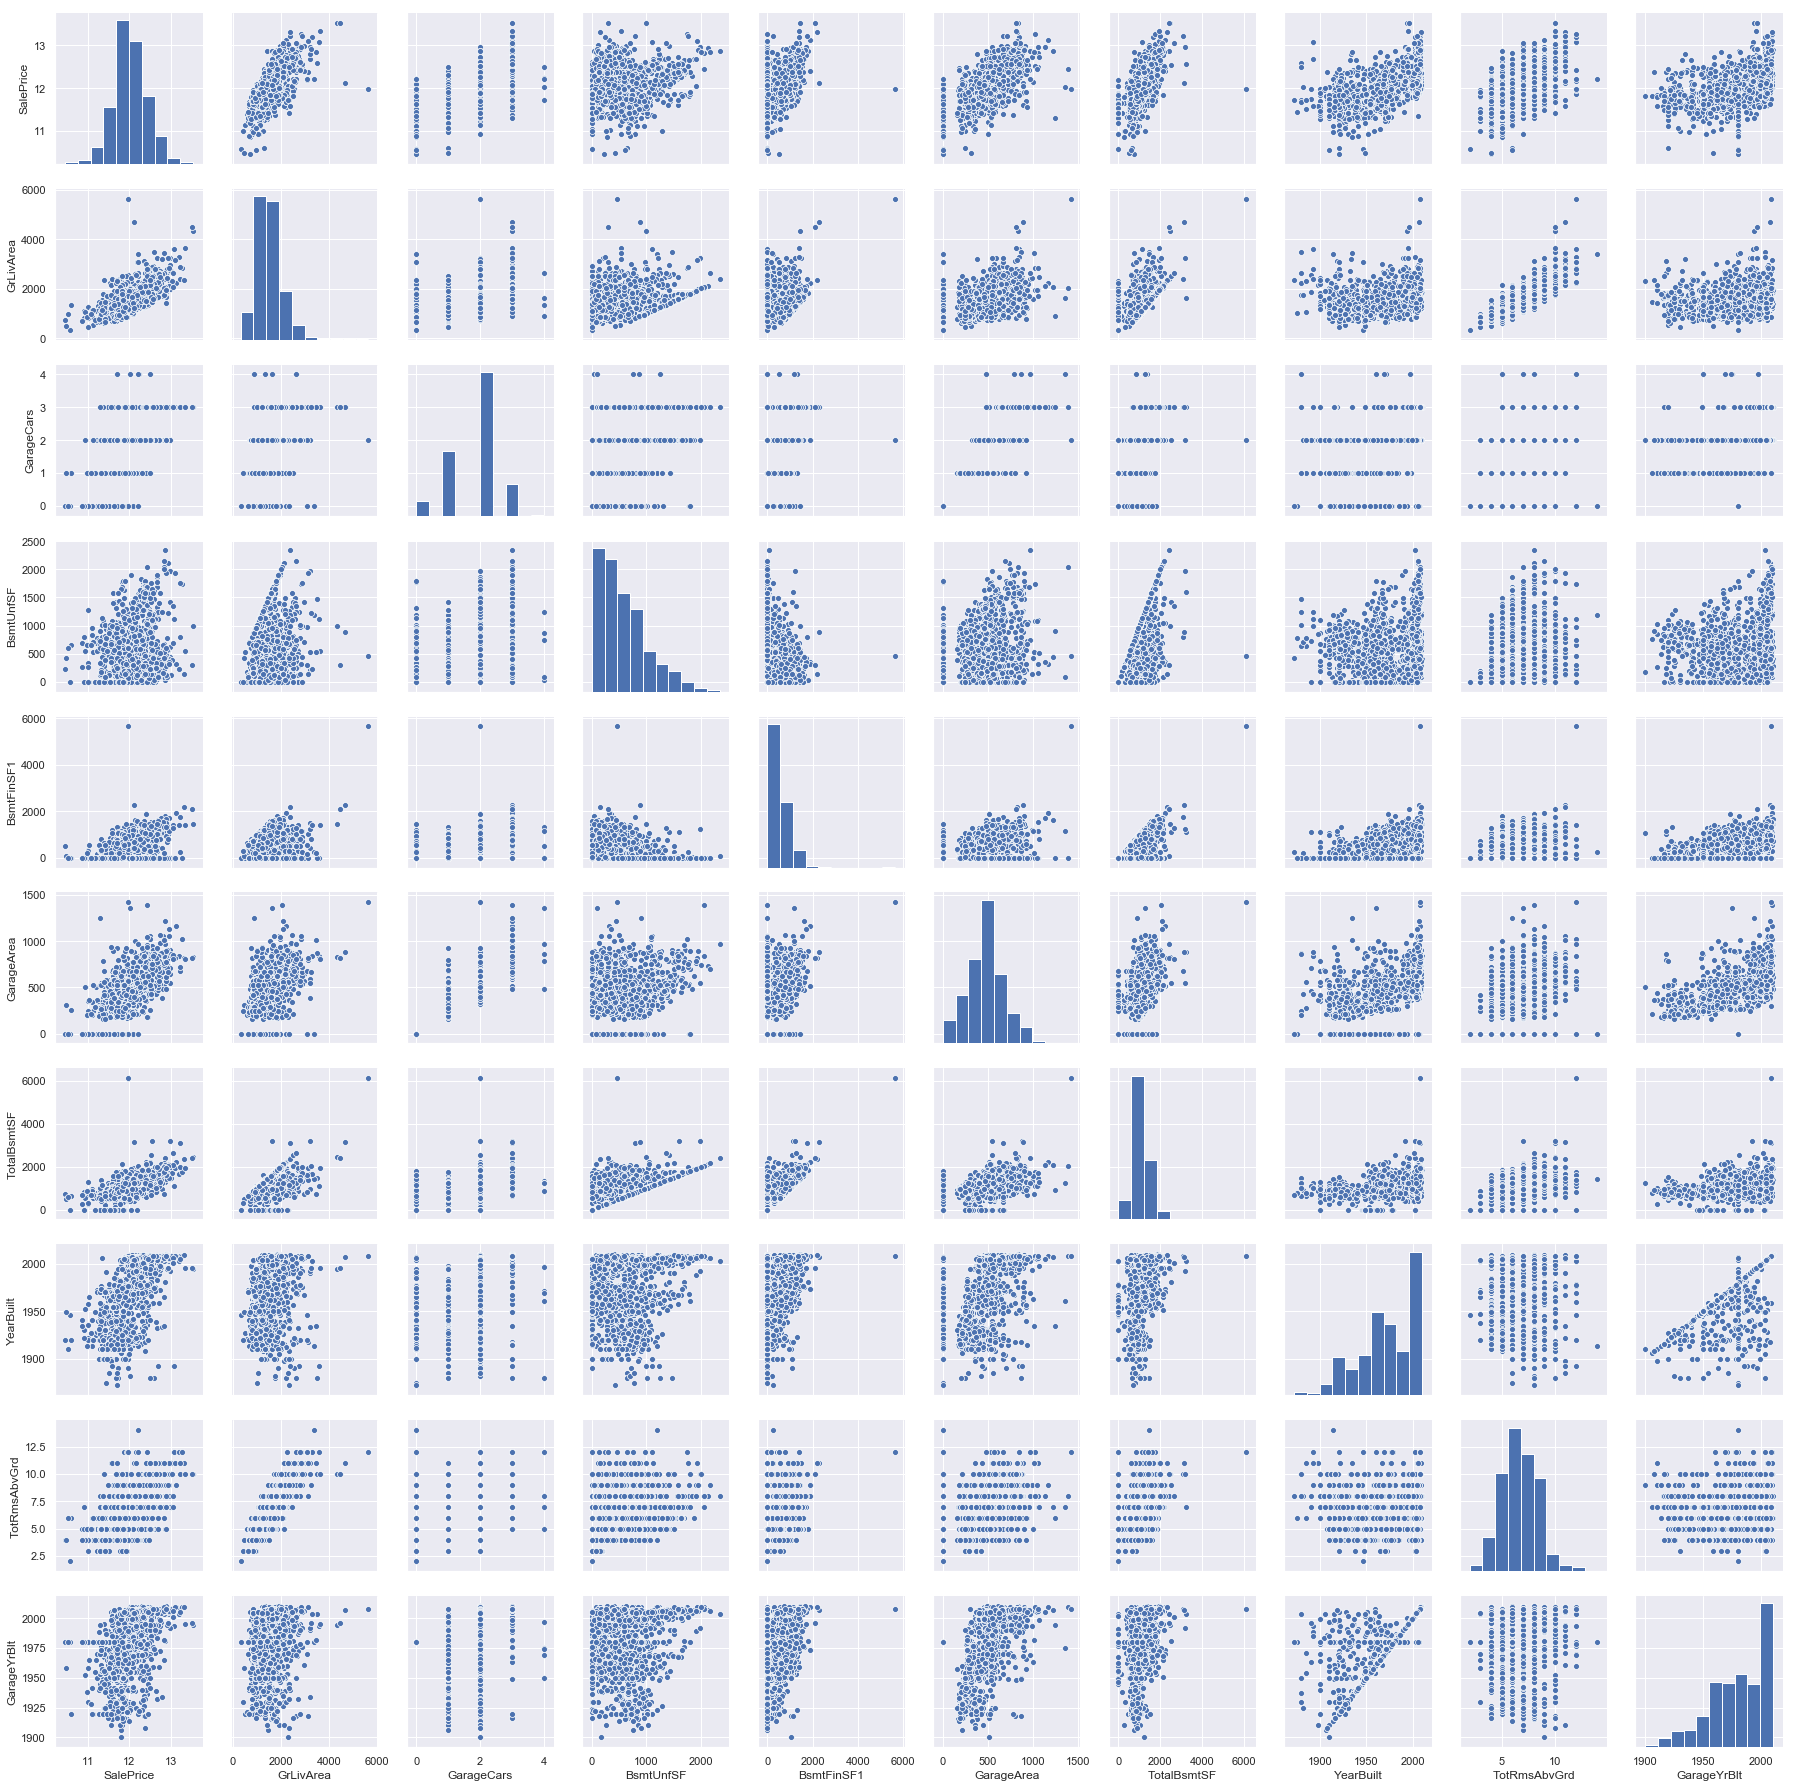

In [155]:
#scatterplot
sns.set()
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'BsmtUnfSF', 'BsmtFinSF1', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd', 'GarageYrBlt']
sns.pairplot(data[cols], size = 2.5)
plt.show()

In [156]:
# Drop columns that are correlated and not contributing to 'SalePrice'

data = data.drop(['GarageCars'], axis = 1)
data = data.drop(['BsmtUnfSF'], axis = 1)
data = data.drop(['TotRmsAbvGrd'], axis = 1)
data = data.drop(['GarageYrBlt'], axis = 1)    

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,12
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,12
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,12
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,12
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,12


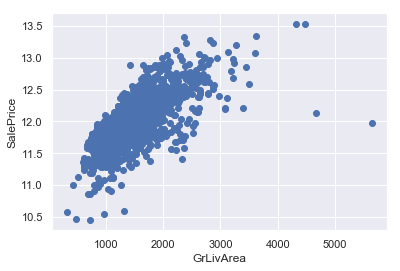

In [157]:
# Analyse some important numeric columns

fig, ax = plt.subplots()
ax.scatter(x = data['GrLivArea'], y = data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

In [158]:
 # removing some outliers on lower right side
data = data.drop(data[(data['GrLivArea']>4000) & (data['SalePrice']<300000)].index)

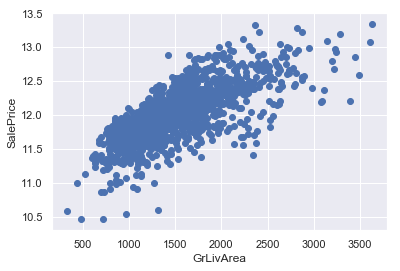

In [159]:
fig, ax = plt.subplots()
ax.scatter(x = data['GrLivArea'], y = data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

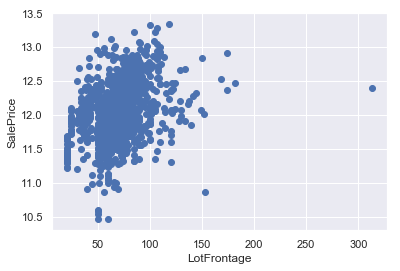

In [160]:
fig, ax = plt.subplots()
ax.scatter(x = data['LotFrontage'], y = data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('LotFrontage')
plt.show()

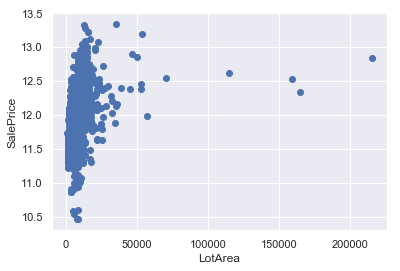

In [161]:
fig, ax = plt.subplots()
ax.scatter(x = data['LotArea'], y = data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('LotArea')
plt.show()

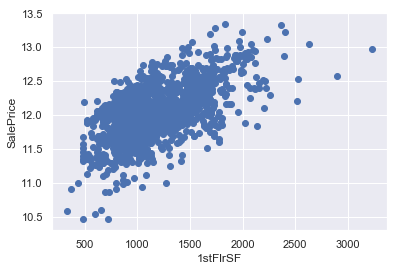

In [162]:
fig, ax = plt.subplots()
ax.scatter(x = data['1stFlrSF'], y = data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('1stFlrSF')
plt.show()

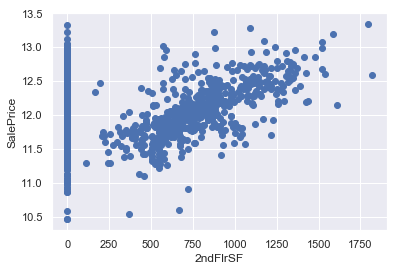

In [163]:
fig, ax = plt.subplots()
ax.scatter(x = data['2ndFlrSF'], y = data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('2ndFlrSF')
plt.show()

In [164]:
# Ground or First level houses i.e. '0' second floor Sq.Ft has also a steady increase

In [165]:
# We can derive a column for 'Age of the property' when it was sold: Name it as 'PropAge'

data['PropAge'] = (data['YrSold'] - data['YearBuilt'])

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PropAge
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,...,None,None,None,0,2,2008,WD,Normal,12,5
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,...,None,None,None,0,5,2007,WD,Normal,12,31
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,...,None,None,None,0,9,2008,WD,Normal,12,7
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,...,None,None,None,0,2,2006,WD,Abnorml,12,91
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,...,None,None,None,0,12,2008,WD,Normal,12,8


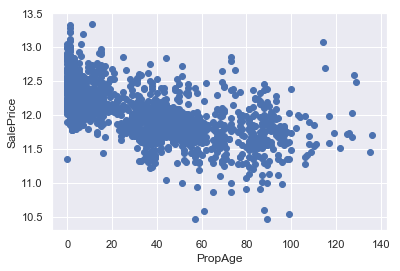

In [166]:
fig, ax = plt.subplots()
ax.scatter(x = data['PropAge'], y = data['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('PropAge')
plt.show()

##### Increase in Property Age shows a decreasing saleprice trend i.e newer the property, high is the value

In [167]:
# we can drop the column Month sold and Year Sold, Year built and Year remodelled since it will not be required further

data = data.drop(['MoSold'], axis = 1)
data = data.drop(['YrSold'], axis = 1)
data = data.drop(['YearBuilt'], axis = 1)
data = data.drop(['YearRemodAdd'], axis = 1)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,PropAge
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,WD,Normal,12,5
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,WD,Normal,12,31
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,WD,Normal,12,7
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,WD,Abnorml,12,91
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,WD,Normal,12,8


In [168]:
data.Street.value_counts()

Pave    1450
Grvl       6
Name: Street, dtype: int64

In [169]:
data.Utilities.value_counts()

AllPub    1455
NoSeWa       1
Name: Utilities, dtype: int64

In [170]:
# We can also drop columns that show very low variance and thus not required for predictions
data = data.drop(['Street'], axis = 1)
data = data.drop(['Utilities'], axis = 1)

In [171]:
data.shape

(1456, 72)

## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [172]:
# Drop 'Id' from Dataframe

data = data.drop(['Id'], axis=1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,PropAge
0,60,RL,65,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,...,0,0,None,None,None,0,WD,Normal,12,5
1,20,RL,80,9600,None,Reg,Lvl,FR2,Gtl,Veenker,...,0,0,None,None,None,0,WD,Normal,12,31
2,60,RL,68,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,...,0,0,None,None,None,0,WD,Normal,12,7
3,70,RL,60,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,...,0,0,None,None,None,0,WD,Abnorml,12,91
4,60,RL,84,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,...,0,0,None,None,None,0,WD,Normal,12,8


In [173]:
types = data.dtypes #type of each feature in data: int, float, object
numeric_type = types[(types == 'int64') | (types == float)] #numerical values are either type int or float
categorical_type = types[types == object] #categorical values are type object

In [174]:
pd.DataFrame(types).reset_index().set_index(0).reset_index()[0].value_counts()

object     41
int64      27
float64     3
Name: 0, dtype: int64

In [175]:
#we should convert numeric_type to a list to make it easier to work with
numerical_columns = list(numeric_type.index)
print(numerical_columns)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice', 'PropAge']


In [176]:
categorical_columns = list(categorical_type.index)
print(categorical_columns)

['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


### Creating Dummy columns to convert categorical into numerical

In [177]:
data = pd.get_dummies(data, drop_first=True )
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65,8450,7,5,2e+02,706,0,856,856,...,0,0,0,0,1,0,0,0,1,0
1,20,80,9600,6,8,0,978,0,1262,1262,...,0,0,0,0,1,0,0,0,1,0
2,60,68,11250,7,5,1.6e+02,486,0,920,920,...,0,0,0,0,1,0,0,0,1,0
3,70,60,9550,7,5,0,216,0,756,961,...,0,0,0,0,1,0,0,0,0,0
4,60,84,14260,8,5,3.5e+02,655,0,1145,1145,...,0,0,0,0,1,0,0,0,1,0


In [178]:
X = data.drop(['SalePrice'], axis=1)

X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65,8450,7,5,2e+02,706,0,856,856,...,0,0,0,0,1,0,0,0,1,0
1,20,80,9600,6,8,0,978,0,1262,1262,...,0,0,0,0,1,0,0,0,1,0
2,60,68,11250,7,5,1.6e+02,486,0,920,920,...,0,0,0,0,1,0,0,0,1,0
3,70,60,9550,7,5,0,216,0,756,961,...,0,0,0,0,1,0,0,0,0,0
4,60,84,14260,8,5,3.5e+02,655,0,1145,1145,...,0,0,0,0,1,0,0,0,1,0


In [179]:
# Putting response variable to y
y = data['SalePrice']

y.head()

0   12
1   12
2   12
3   12
4   12
Name: SalePrice, dtype: float64

In [180]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=50)

In [181]:
from sklearn.preprocessing import StandardScaler

In [182]:
scaler = StandardScaler()

X_train[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
          'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
           'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces','GarageArea', 'WoodDeckSF', 'OpenPorchSF',
           'EnclosedPorch', '3SsnPorch','ScreenPorch', 'PoolArea', 'MiscVal',
          'PropAge']] = scaler.fit_transform(X_train[['MSSubClass', 'LotFrontage', 'LotArea','OverallQual', 'OverallCond',
                                                       'MasVnrArea','BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
                                                       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                                                       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                                                        'KitchenAbvGr', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 
                                                        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                                                        'PoolArea', 'MiscVal','PropAge']])
X_test[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
          'TotalBsmtSF', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
           'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces','GarageArea', 'WoodDeckSF', 'OpenPorchSF',
           'EnclosedPorch', '3SsnPorch','ScreenPorch', 'PoolArea', 'MiscVal',
          'PropAge']] = scaler.transform(X_test[['MSSubClass', 'LotFrontage', 'LotArea','OverallQual', 'OverallCond',
                                                       'MasVnrArea','BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
                                                       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                                                       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                                                        'KitchenAbvGr', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 
                                                        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                                                        'PoolArea', 'MiscVal','PropAge']])


In [183]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
905,-0.87,0.43,-0.064,-0.77,-0.51,0.051,-0.17,1.5,0.036,-0.25,...,0,0,0,0,1,0,0,0,1,0
708,0.082,-0.25,-0.14,0.67,-0.51,-0.6,-1,-0.29,-0.76,-1.2,...,0,0,1,0,0,0,0,0,0,1
496,-0.87,0.94,0.18,1.4,-0.51,-0.6,1.9,-0.29,5.2,5.6,...,0,0,0,0,1,0,0,0,1,0
127,-0.28,-0.71,-0.56,-0.77,1.3,-0.6,-0.73,-0.29,-0.89,-0.85,...,0,0,0,0,1,0,0,0,1,0
916,-0.87,-0.94,-0.15,-2.9,-2.3,-0.6,-0.88,-0.29,-1.4,-1.8,...,0,0,0,0,1,0,0,0,0,0


In [184]:
X_test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
836,-0.63,0.89,-0.23,-0.77,0.38,-0.6,-0.21,-0.29,1.3,1.1,...,0,0,0,0,0,0,0,0,1,0
1027,-0.87,0.022,-0.1,1.4,-0.51,1.4,2.5,-0.29,1.4,1.3,...,0,0,1,0,0,0,0,0,0,1
924,-0.87,0.39,-0.036,-0.05,0.38,0.33,0.46,6.4,1.6,1.4,...,0,0,0,0,1,0,0,0,1,0
215,-0.87,0.067,-0.056,-0.77,0.38,-0.22,-0.16,-0.29,0.07,0.22,...,0,0,0,0,1,0,0,0,1,0
233,-0.87,0.2,0.00077,-0.77,0.38,-0.6,-0.57,4.2,-0.36,-0.71,...,0,0,0,0,1,0,0,0,1,0


## 3. Model Building and Evaluation

### Lets first check the model using Linear Regression and RFE

In [185]:
# Importing RFE and LinearRegression
# Since there are more variables to be analysed, we will used the automated feature elimination process (RFE)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [186]:
# Running RFE 
# Since there are more than 250 variables for analysis, we will run RFE to select some that have high predictive power
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 100)             # running RFE for top 80 variables
rfe = rfe.fit(X_train, y_train)

In [187]:
# Check the ranks
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 96),
 ('LotFrontage', False, 97),
 ('LotArea', False, 28),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('MasVnrArea', False, 140),
 ('BsmtFinSF1', False, 4),
 ('BsmtFinSF2', False, 41),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 84),
 ('BsmtHalfBath', False, 124),
 ('FullBath', False, 107),
 ('HalfBath', False, 109),
 ('BedroomAbvGr', False, 127),
 ('KitchenAbvGr', False, 53),
 ('Fireplaces', False, 129),
 ('GarageArea', False, 14),
 ('WoodDeckSF', False, 83),
 ('OpenPorchSF', False, 146),
 ('EnclosedPorch', False, 71),
 ('3SsnPorch', False, 113),
 ('ScreenPorch', False, 82),
 ('PoolArea', False, 54),
 ('MiscVal', False, 148),
 ('PropAge', True, 1),
 ('MSZoning_FV', True, 1),
 ('MSZoning_RH', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', True, 1),
 ('Alley_None', False, 94),
 ('Alley_Pave', False, 101),
 ('LotShape_IR2', False, 59),
 ('

In [188]:
# Select the top 100 variables

col = X_train.columns[rfe.support_]
col

Index(['OverallQual', 'OverallCond', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'PropAge', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'LotConfig_FR3', 'Neighborhood_BrDale',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_OldTown',
       'Neighborhood_Sawyer', 'Neighborhood_StoneBr', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRAn', 'Condition1_RRNe', 'Condition2_Feedr',
       'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',
       'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'RoofStyle_Shed',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exter

In [189]:
X_train.columns[~rfe.support_]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       ...
       'MiscFeature_None', 'MiscFeature_Shed', 'MiscFeature_TenC',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family'],
      dtype='object', length=149)

In [190]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [191]:
X_train_rfe = pd.DataFrame(X_train[col])

In [192]:
X_train_rfe.head()

,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,PropAge,MSZoning_FV,MSZoning_RH,...,PoolQC_Gd,PoolQC_None,Fence_GdWo,MiscFeature_Othr,SaleType_CWD,SaleType_Con,SaleType_ConLw,SaleType_New,SaleCondition_Normal,SaleCondition_Partial
905,-0.77,-0.51,0.036,-0.25,-0.8,-0.12,-0.89,0.67,0,0,...,0,1,0,0,0,0,0,0,1,0
708,0.67,-0.51,-0.76,-1.2,0.88,-0.12,-0.1,-1.2,0,0,...,0,1,0,0,0,0,0,1,0,1
496,1.4,-0.51,5.2,5.6,-0.8,-0.12,3.4,-0.71,0,0,...,0,1,0,0,0,0,0,0,1,0
127,-0.77,1.3,-0.89,-0.85,-0.8,-0.12,-1.3,1.4,0,0,...,0,1,0,0,0,0,0,0,1,0
916,-2.9,-2.3,-1.4,-1.8,-0.8,-0.12,-2.1,0.7,0,0,...,0,1,0,0,0,0,0,0,0,0


In [193]:
X_train_rfe.shape

(1019, 100)

In [194]:
# predict
y_train_pred = lm.predict(X_train)
metrics.r2_score(y_true=y_train, y_pred=y_train_pred)

0.9548687255412867

In [195]:
y_test_pred = lm.predict(X_test)
metrics.r2_score(y_true=y_test, y_pred=y_test_pred)

-1.8499843274341822e+19

#### Since the Test R2 is too low, we will check for some alternate methods of Regression

In [196]:
# Check the ranks
list(zip(X_test.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 96),
 ('LotFrontage', False, 97),
 ('LotArea', False, 28),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('MasVnrArea', False, 140),
 ('BsmtFinSF1', False, 4),
 ('BsmtFinSF2', False, 41),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 84),
 ('BsmtHalfBath', False, 124),
 ('FullBath', False, 107),
 ('HalfBath', False, 109),
 ('BedroomAbvGr', False, 127),
 ('KitchenAbvGr', False, 53),
 ('Fireplaces', False, 129),
 ('GarageArea', False, 14),
 ('WoodDeckSF', False, 83),
 ('OpenPorchSF', False, 146),
 ('EnclosedPorch', False, 71),
 ('3SsnPorch', False, 113),
 ('ScreenPorch', False, 82),
 ('PoolArea', False, 54),
 ('MiscVal', False, 148),
 ('PropAge', True, 1),
 ('MSZoning_FV', True, 1),
 ('MSZoning_RH', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', True, 1),
 ('Alley_None', False, 94),
 ('Alley_Pave', False, 101),
 ('LotShape_IR2', False, 59),
 ('

In [197]:
# Select the top 100 variables

col1 = X_test.columns[rfe.support_]
col1

Index(['OverallQual', 'OverallCond', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'PropAge', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'LotConfig_FR3', 'Neighborhood_BrDale',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_OldTown',
       'Neighborhood_Sawyer', 'Neighborhood_StoneBr', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRAn', 'Condition1_RRNe', 'Condition2_Feedr',
       'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',
       'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'RoofStyle_Shed',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exter

In [198]:
X_test_rfe = X_test[col1]

In [199]:
X_test_rfe.head()

,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,PropAge,MSZoning_FV,MSZoning_RH,...,PoolQC_Gd,PoolQC_None,Fence_GdWo,MiscFeature_Othr,SaleType_CWD,SaleType_Con,SaleType_ConLw,SaleType_New,SaleCondition_Normal,SaleCondition_Partial
836,-0.77,0.38,1.3,1.1,-0.8,-0.12,0.1,0.77,0,0,...,0,1,1,0,0,0,0,0,1,0
1027,1.4,-0.51,1.4,1.3,-0.8,-0.12,0.28,-1.2,0,0,...,0,1,0,0,0,0,0,1,0,1
924,-0.05,0.38,1.6,1.4,-0.8,-0.12,0.36,-0.34,0,0,...,0,1,0,0,0,0,0,0,1,0
215,-0.77,0.38,0.07,0.22,-0.8,-0.12,-0.54,0.43,0,0,...,0,1,0,0,0,0,0,0,1,0
233,-0.77,0.38,-0.36,-0.71,-0.8,-0.12,-1.2,-0.072,0,0,...,0,1,0,0,0,0,0,0,1,0


## Ridge and Lasso Regression

Let's now try predicting house prices and perform ridge and lasso regression.

## Lasso Regression

In [200]:
# Applying Lasso

# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    6.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [201]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=1]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.46,0.058,0.0016,0.00047,0.0001,{'alpha': 0.0001},-0.088,-0.079,-0.075,-0.087,...,-0.084,0.0062,2,-0.061,-0.063,-0.063,-0.062,-0.061,-0.062,0.0012
1,0.098,0.0078,0.0016,0.00049,0.001,{'alpha': 0.001},-0.088,-0.073,-0.073,-0.083,...,-0.082,0.0084,1,-0.072,-0.077,-0.077,-0.075,-0.072,-0.074,0.0021
2,0.029,0.0018,0.002,0.00063,0.01,{'alpha': 0.01},-0.096,-0.082,-0.081,-0.099,...,-0.092,0.009,3,-0.089,-0.092,-0.093,-0.089,-0.088,-0.09,0.0019
3,0.025,0.0028,0.0018,0.0004,0.05,{'alpha': 0.05},-0.12,-0.098,-0.11,-0.13,...,-0.12,0.012,4,-0.12,-0.12,-0.12,-0.12,-0.11,-0.12,0.0018
4,0.023,0.0026,0.0014,0.00049,0.1,{'alpha': 0.1},-0.16,-0.12,-0.15,-0.17,...,-0.15,0.015,5,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,0.0016


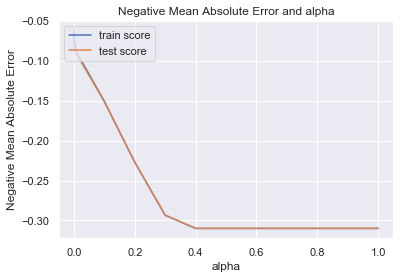

In [202]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

#### The Negative Mean Absolute Error is quite low at alpha = 0.4 and stabilises thereafter, 
#### but we will choose a low value of alpha to balance the trade-off between Bias-Variance 
#### and to get the coefficients of smallest of features.

In [203]:
# At alpha = 0.01, even the smallest of negative coefficients that have some predictive power towards 'SalePrice' have been generated

alpha = 0.01
lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)
lasso.coef_

array([-0.00467488,  0.00770501,  0.0170413 ,  0.11205278,  0.05111723,
        0.        ,  0.03187967,  0.        ,  0.04952996,  0.        ,
        0.        , -0.00043704,  0.13367767,  0.00625252, -0.        ,
        0.00405464,  0.        , -0.        , -0.00997479,  0.0235696 ,
        0.03924559,  0.00346837,  0.00538356, -0.        ,  0.        ,
        0.00300535,  0.        , -0.        , -0.09753094,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.  

#### The advantage of this technique is clearly visible here as Lasso brings the coefficients of insignificant features to zero

In [204]:
# lasso model parameters
model_parameters = list(lasso.coef_ )
model_parameters.insert(0, lasso.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 12.019),
 ('MSSubClass', -0.005),
 ('LotFrontage', 0.008),
 ('LotArea', 0.017),
 ('OverallQual', 0.112),
 ('OverallCond', 0.051),
 ('MasVnrArea', 0.0),
 ('BsmtFinSF1', 0.032),
 ('BsmtFinSF2', 0.0),
 ('TotalBsmtSF', 0.05),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', -0.0),
 ('GrLivArea', 0.134),
 ('BsmtFullBath', 0.006),
 ('BsmtHalfBath', -0.0),
 ('FullBath', 0.004),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', -0.0),
 ('KitchenAbvGr', -0.01),
 ('Fireplaces', 0.024),
 ('GarageArea', 0.039),
 ('WoodDeckSF', 0.003),
 ('OpenPorchSF', 0.005),
 ('EnclosedPorch', -0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.003),
 ('PoolArea', 0.0),
 ('MiscVal', -0.0),
 ('PropAge', -0.098),
 ('MSZoning_FV', 0.0),
 ('MSZoning_RH', -0.0),
 ('MSZoning_RL', 0.0),
 ('MSZoning_RM', -0.0),
 ('Alley_None', 0.0),
 ('Alley_Pave', -0.0),
 ('LotShape_IR2', 0.0),
 ('LotShape_IR3', 0.0),
 ('LotShape_Reg', -0.0),
 ('LandContour_HLS', 0.0),
 ('LandContour_Low', 0.0),
 ('LandContour_Lvl', -0.0),
 ('LotC

In [205]:
# lasso regression
lm = Lasso(alpha=0.01)
lm.fit(X_train, y_train)

# prediction on the test set(Using R2)
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.896527408011395
0.8851584238168858


In [206]:
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

RMSE : 0.13181094844053554


#### The R2 values for Train and Test matches well, indicating an optimum model

In [207]:
# Create a dataframe for the coefficients obtained from Lasso
mod = list(zip(cols, model_parameters))

In [208]:
para = pd.DataFrame(mod)
para.columns = ['Variable', 'Coeff']
para.head()

,Variable,Coeff
0,constant,12
1,MSSubClass,-0.005
2,LotFrontage,0.008
3,LotArea,0.017
4,OverallQual,0.11


In [209]:
# sort the coefficients in ascending order
para = para.sort_values((['Coeff']), axis = 0, ascending = False)
para

,Variable,Coeff
0,constant,12
13,GrLivArea,0.13
4,OverallQual,0.11
5,OverallCond,0.051
9,TotalBsmtSF,0.05
21,GarageArea,0.039
7,BsmtFinSF1,0.032
20,Fireplaces,0.024
3,LotArea,0.017
2,LotFrontage,0.008


In [210]:
# Chose variables whose coefficients are non-zero
pred = pd.DataFrame(para[(para['Coeff'] != 0)])
pred

,Variable,Coeff
0,constant,12
13,GrLivArea,0.13
4,OverallQual,0.11
5,OverallCond,0.051
9,TotalBsmtSF,0.05
21,GarageArea,0.039
7,BsmtFinSF1,0.032
20,Fireplaces,0.024
3,LotArea,0.017
2,LotFrontage,0.008


In [211]:
# These 16 variables obtained from Lasso Regression can be concluded to have the strong effect on the SalePrice
pred.shape

(19, 2)

In [212]:
Lassso_var = list(pred['Variable'])
print(Lassso_var)

['constant', 'GrLivArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'Fireplaces', 'LotArea', 'LotFrontage', 'BsmtFullBath', 'Foundation_PConc', 'OpenPorchSF', 'FullBath', 'ScreenPorch', 'WoodDeckSF', 'MSSubClass', 'KitchenAbvGr', 'PropAge']


In [213]:
X_train_lasso = X_train[['GrLivArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'Fireplaces', 'LotArea', 'LotFrontage', 'BsmtFullBath', 'Foundation_PConc', 'OpenPorchSF', 'FullBath', 'ScreenPorch', 'WoodDeckSF']]
                        
X_train_lasso.head()

,GrLivArea,OverallQual,OverallCond,TotalBsmtSF,GarageArea,BsmtFinSF1,Fireplaces,LotArea,LotFrontage,BsmtFullBath,Foundation_PConc,OpenPorchSF,FullBath,ScreenPorch,WoodDeckSF
905,-0.89,-0.77,-0.51,0.036,-0.9,-0.17,-0.95,-0.064,0.43,1.1,0,-0.7,-1,-0.26,-0.75
708,-0.1,0.67,-0.51,-0.76,-0.34,-1,0.61,-0.14,-0.25,-0.8,1,-0.33,0.8,-0.26,0.057
496,3.4,1.4,-0.51,5.2,0.34,1.9,0.61,0.18,0.94,1.1,1,0.45,2.6,-0.26,1.4
127,-1.3,-0.77,1.3,-0.89,-2.2,-0.73,0.61,-0.56,-0.71,-0.8,0,-0.7,-1,-0.26,-0.75
916,-2.1,-2.9,-2.3,-1.4,-0.77,-0.88,-0.95,-0.15,-0.94,1.1,0,-0.7,-2.8,-0.26,-0.75


In [214]:
X_train_lasso.shape

(1019, 15)

In [215]:
X_test_lasso = X_test[['GrLivArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GarageArea', 'BsmtFinSF1', 'Fireplaces', 'LotArea', 'LotFrontage', 'BsmtFullBath', 'Foundation_PConc', 'OpenPorchSF', 'FullBath', 'ScreenPorch', 'WoodDeckSF']]
                        
X_test_lasso.head()

,GrLivArea,OverallQual,OverallCond,TotalBsmtSF,GarageArea,BsmtFinSF1,Fireplaces,LotArea,LotFrontage,BsmtFullBath,Foundation_PConc,OpenPorchSF,FullBath,ScreenPorch,WoodDeckSF
836,0.1,-0.77,0.38,1.3,1.6,-0.21,-0.95,-0.23,0.89,1.1,0,1.1,-1,-0.26,-0.75
1027,0.28,1.4,-0.51,1.4,1.5,2.5,0.61,-0.1,0.022,1.1,1,-0.021,0.8,-0.26,0.8
924,0.36,-0.05,0.38,1.6,0.65,0.46,0.61,-0.036,0.39,1.1,0,1.3,0.8,-0.26,2.3
215,-0.54,-0.77,0.38,0.07,-0.12,-0.16,0.61,-0.056,0.067,-0.8,0,-0.7,-1,-0.26,-0.75
233,-1.2,-0.77,0.38,-0.36,-0.77,-0.57,-0.95,0.00077,0.2,1.1,0,-0.7,-1,-0.26,2.2


## Ridge Regression

In [216]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    5.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [217]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=5]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.14,0.21,0.002,2.2e-06,0.0001,{'alpha': 0.0001},-0.091,-0.086,-0.082,-0.098,...,-0.091,0.0068,27,-0.057,-0.06,-0.06,-0.059,-0.057,-0.059,0.0014
1,0.022,0.0026,0.0016,0.00081,0.001,{'alpha': 0.001},-0.091,-0.086,-0.082,-0.097,...,-0.091,0.0068,25,-0.057,-0.06,-0.06,-0.059,-0.057,-0.059,0.0014
2,0.026,0.0043,0.0016,0.00049,0.01,{'alpha': 0.01},-0.091,-0.085,-0.082,-0.096,...,-0.09,0.0066,24,-0.057,-0.06,-0.06,-0.059,-0.057,-0.059,0.0014
3,0.026,0.0021,0.002,0.0009,0.05,{'alpha': 0.05},-0.09,-0.083,-0.081,-0.094,...,-0.089,0.0065,23,-0.057,-0.06,-0.06,-0.06,-0.057,-0.059,0.0014
4,0.03,0.0026,0.0016,0.00049,0.1,{'alpha': 0.1},-0.09,-0.082,-0.08,-0.093,...,-0.088,0.0066,22,-0.058,-0.061,-0.061,-0.06,-0.058,-0.059,0.0014


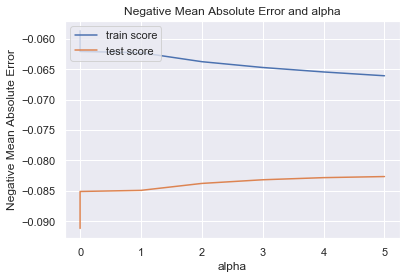

In [218]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [219]:
# since the Negative Mean Absolute Error stabilises at alpha = 2, we will choose this for further analysis
alpha = 2
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-1.22790117e-02,  7.45789656e-03,  2.33276411e-02,  6.66851201e-02,
        5.29179947e-02,  7.60281695e-04,  2.85845803e-02,  1.84105982e-02,
        4.21662488e-02,  4.26284495e-02,  4.42314764e-02, -3.59152182e-03,
        6.95978743e-02,  9.95661328e-03, -2.64615750e-03,  1.40527250e-02,
        1.19066515e-02,  3.79977743e-03, -1.34166910e-02,  4.37106071e-03,
        2.54410160e-02,  1.33767471e-02,  8.90060588e-03,  1.00730255e-02,
        6.66864319e-03,  1.14065386e-02,  7.17742067e-03,  1.01044362e-03,
       -5.86031959e-02,  1.16067452e-01,  1.48889477e-01,  1.39340662e-01,
        1.16677489e-01, -7.22732287e-03, -1.78460339e-02,  2.83101721e-02,
        2.35833283e-02,  1.02778624e-02,  6.08932005e-04, -2.43245861e-02,
       -1.70108121e-03,  3.61094190e-02, -1.38983379e-02, -4.87375602e-02,
       -3.78543442e-03, -8.52894505e-03, -1.12442029e-01, -6.36055416e-03,
       -6.39562367e-02,  3.73115396e-03,  3.44607221e-02, -2.51448612e-02,
        1.12396273e-01, -

In [220]:
# ridge model parameters
model_parameters = list(ridge.coef_)
model_parameters.insert(0, ridge.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
list(zip(cols, model_parameters))

[('constant', 11.598),
 ('MSSubClass', -0.012),
 ('LotFrontage', 0.007),
 ('LotArea', 0.023),
 ('OverallQual', 0.067),
 ('OverallCond', 0.053),
 ('MasVnrArea', 0.001),
 ('BsmtFinSF1', 0.029),
 ('BsmtFinSF2', 0.018),
 ('TotalBsmtSF', 0.042),
 ('1stFlrSF', 0.043),
 ('2ndFlrSF', 0.044),
 ('LowQualFinSF', -0.004),
 ('GrLivArea', 0.07),
 ('BsmtFullBath', 0.01),
 ('BsmtHalfBath', -0.003),
 ('FullBath', 0.014),
 ('HalfBath', 0.012),
 ('BedroomAbvGr', 0.004),
 ('KitchenAbvGr', -0.013),
 ('Fireplaces', 0.004),
 ('GarageArea', 0.025),
 ('WoodDeckSF', 0.013),
 ('OpenPorchSF', 0.009),
 ('EnclosedPorch', 0.01),
 ('3SsnPorch', 0.007),
 ('ScreenPorch', 0.011),
 ('PoolArea', 0.007),
 ('MiscVal', 0.001),
 ('PropAge', -0.059),
 ('MSZoning_FV', 0.116),
 ('MSZoning_RH', 0.149),
 ('MSZoning_RL', 0.139),
 ('MSZoning_RM', 0.117),
 ('Alley_None', -0.007),
 ('Alley_Pave', -0.018),
 ('LotShape_IR2', 0.028),
 ('LotShape_IR3', 0.024),
 ('LotShape_Reg', 0.01),
 ('LandContour_HLS', 0.001),
 ('LandContour_Low', -0.0

In [221]:
# ridge regression
lm = Ridge(alpha=2)
lm.fit(X_train, y_train)

# predict
y_train_pred = lm.predict(X_train)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.9490267913063958
0.9034534144228399


In [222]:
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

RMSE : 0.12085660003326111


##### It is visible that the model performance is better than Lasso.  The train and the test scores are matching well

In [223]:
# Create a dataframe for Ridge Coefficients
mod_ridge = list(zip(cols, model_parameters))

In [224]:
paraRFE = pd.DataFrame(mod_ridge)
paraRFE.columns = ['Variable', 'Coeff']
paraRFE.head()

,Variable,Coeff
0,constant,12
1,MSSubClass,-0.012
2,LotFrontage,0.007
3,LotArea,0.023
4,OverallQual,0.067


In [225]:
# Sorting the coefficients in ascending order
paraRFE = paraRFE.sort_values((['Coeff']), axis = 0, ascending = False)
paraRFE

,Variable,Coeff
0,constant,12
31,MSZoning_RH,0.15
32,MSZoning_RL,0.14
242,SaleType_New,0.13
33,MSZoning_RM,0.12
30,MSZoning_FV,0.12
53,Neighborhood_Crawfor,0.11
69,Neighborhood_StoneBr,0.11
103,RoofMatl_Membran,0.09
159,BsmtCond_Po,0.084


In [226]:
## since there were few coefficients at 0, we removed them from features
predRFE = pd.DataFrame(paraRFE[(paraRFE['Coeff'] != 0)])
predRFE

,Variable,Coeff
0,constant,12
31,MSZoning_RH,0.15
32,MSZoning_RL,0.14
242,SaleType_New,0.13
33,MSZoning_RM,0.12
30,MSZoning_FV,0.12
53,Neighborhood_Crawfor,0.11
69,Neighborhood_StoneBr,0.11
103,RoofMatl_Membran,0.09
159,BsmtCond_Po,0.084


In [227]:
predRFE.shape

(240, 2)

### Observation:
Though the model performance by Ridge Regression was better in terms of R2 values of Train and Test, 
it is better to use Lasso, since it brings assigns a zero value to insignificant features, enabling us to choose
the predictive variables.

In [228]:
#### Equation can be formulated using the features and coefficients obtained by Lasso

In [229]:
### Assign the Features as x1, x2.....

pred.set_index(pd.Index(['C','x1', 'x2', 'x3', 'x4', 'x5' , 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18']), inplace = True) 
pred

,Variable,Coeff
C,constant,12
x1,GrLivArea,0.13
x2,OverallQual,0.11
x3,OverallCond,0.051
x4,TotalBsmtSF,0.05
x5,GarageArea,0.039
x6,BsmtFinSF1,0.032
x7,Fireplaces,0.024
x8,LotArea,0.017
x9,LotFrontage,0.008


### These are the final features that should be selected for predicting the price of house

### Hence the equation:
    
####    Log(Y) = C + 0.13(x1) + 0.112(x2) +  0.051(x3) + 0.050(x4) + 0.039(x5) + 0.032(x6) + 0.024(x7) +  0.017(x8) + 0.008(x9) + 0.006(x10)
####                + 0.005(x11) + 0.005(x12) + 0.004(x13) + 0.003(x14) + 0.003(x15) - 0.005(x16) - 0.010(x17) - 0.098(x18) + Error term(RSS + alpha * (sum of absolute value of coefficients)

### Suggestions for Surprise Housing

#### These predictors affecting the price of the house should be kept in check.  
#### The higher values of positive coeeficients suggest a high sale value.
#### The higher values of negative coeeficients (Eg. Age of the property) suggest a decrease in sale value.
#### When the market value of the property is lower than the Predicted Sale Price, its the time to buy.
#### When market values reach the Predicted sale values or higher, its time to flip.